# Car Part Detection

Problem: Non-car savy people can easily get scammed by garages when they cannot identify the part that is causing the problem. 

Creating an application that can identify a part for a car owner allows them to research more into the part and what may be causing an issue.

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
# CHECKING IF GOOGLE COLAB ENVIRONMENT OR LOCAL

GOOGLE_COLAB = False
DATASET_ROOT = 'datasets/car_part/'

try:
    import google_colab
    GOOGLE_COLAB = True
    DATASET_ROOT = '/content/car_part/'
except ImportError:
    GOOGLE_COLAB = False
    DATASET_ROOT = 'datasets/car_part/'

## Loading Data

In [121]:
train_df = pd.read_csv(DATASET_ROOT + "train_car.csv")
train_df

,class index,filepaths,labels,data set
0,0,train/AIR COMPRESSOR/001.jpg,AIR COMPRESSOR,train
1,0,train/AIR COMPRESSOR/002.jpg,AIR COMPRESSOR,train
2,0,train/AIR COMPRESSOR/003.jpg,AIR COMPRESSOR,train
3,0,train/AIR COMPRESSOR/004.jpg,AIR COMPRESSOR,train
4,0,train/AIR COMPRESSOR/005.jpg,AIR COMPRESSOR,train
...,...,...,...,...
8734,49,train/WINDOW REGULATOR/175.jpg,WINDOW REGULATOR,train
8735,49,train/WINDOW REGULATOR/176.jpg,WINDOW REGULATOR,train
8736,49,train/WINDOW REGULATOR/177.jpg,WINDOW REGULATOR,train
8737,49,train/WINDOW REGULATOR/178.jpg,WINDOW REGULATOR,train


In [122]:
# add DATASET_ROOT + /car_part/ to filepaths
train_df['filepaths'] = train_df['filepaths'].apply(lambda path: DATASET_ROOT + path)
train_df

,class index,filepaths,labels,data set
0,0,datasets/car_part/train/AIR COMPRESSOR/001.jpg,AIR COMPRESSOR,train
1,0,datasets/car_part/train/AIR COMPRESSOR/002.jpg,AIR COMPRESSOR,train
2,0,datasets/car_part/train/AIR COMPRESSOR/003.jpg,AIR COMPRESSOR,train
3,0,datasets/car_part/train/AIR COMPRESSOR/004.jpg,AIR COMPRESSOR,train
4,0,datasets/car_part/train/AIR COMPRESSOR/005.jpg,AIR COMPRESSOR,train
...,...,...,...,...
8734,49,datasets/car_part/train/WINDOW REGULATOR/175.jpg,WINDOW REGULATOR,train
8735,49,datasets/car_part/train/WINDOW REGULATOR/176.jpg,WINDOW REGULATOR,train
8736,49,datasets/car_part/train/WINDOW REGULATOR/177.jpg,WINDOW REGULATOR,train
8737,49,datasets/car_part/train/WINDOW REGULATOR/178.jpg,WINDOW REGULATOR,train


## EDA

### Class Balance

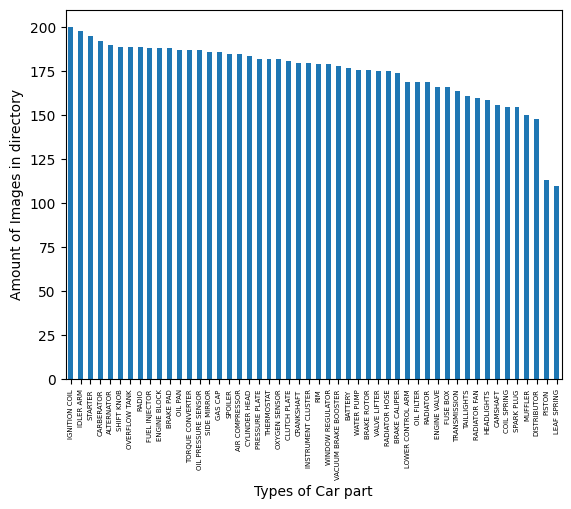

In [195]:
train_df['labels'].value_counts().plot(kind="bar")

plt.tick_params(axis='x', which='major', labelsize=5)
plt.xlabel("Types of Car part")
plt.ylabel("Amount of Images in directory")

plt.show()

This shows a somewhat even distribution between classes is somewhat even. There might be some bias towards the classes with the highest images 

### Image Size

In [144]:
from PIL import Image
from tqdm import tqdm

In [142]:
def get_dim(file):
    """
        Returns the image height & width
    """
    img = Image.open(file)
    arr = np.array(img)
    dims = arr.shape
    return (dims[0], dims[1])

In [147]:
# create new df for plotting image dimensions
filepaths = train_df['filepaths']

dims = []
for path in tqdm(filepaths):
    dims.append(get_dim(path))

100%|██████████| 8739/8739 [00:04<00:00, 2041.85it/s]


In [149]:
res_df = pd.DataFrame(dims, columns=['height', 'width'])
res_df

,height,width
0,224,224
1,224,224
2,224,224
3,224,224
4,224,224
...,...,...
8734,224,224
8735,224,224
8736,224,224
8737,224,224


Text(0.5, 1.0, 'Image Resolution')

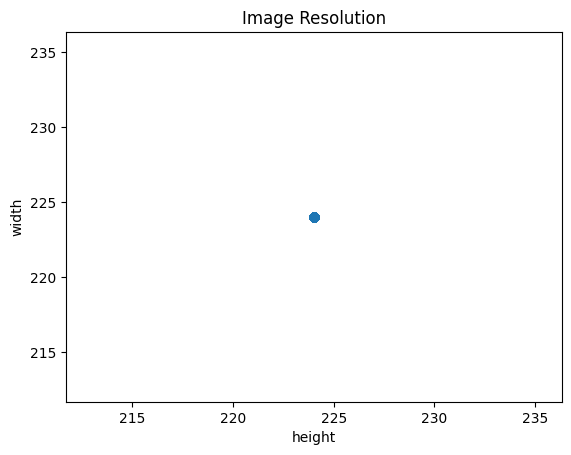

In [153]:
# plot into scatter plot
fig, axes = plt.subplots()

axes.scatter(x=res_df['width'], y=res_df['height'])
axes.set_xlabel("height")
axes.set_ylabel("width")

axes.set_title("Image Resolution")

All images are uniform resolution. No resizing needed

### Image Sampling

In [170]:
import random
import cv2

In [192]:
# generate 4 random image index
img_inds = []
for i in range(0,5):
    img_inds.append(random.randint(0, len(train_df)))

img_inds

[4449, 860, 5133, 6439, 7622]

(-0.5, 223.5, 223.5, -0.5)

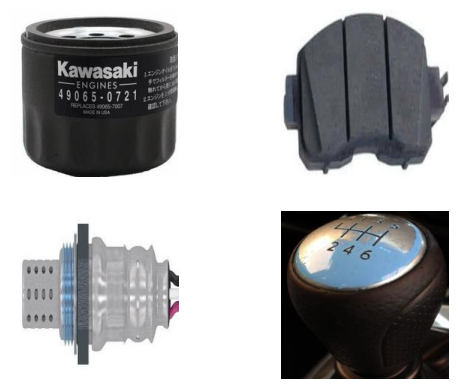

In [193]:
fig, axes = plt.subplots(2, 2)

axes[0, 0].imshow(cv2.imread(train_df.loc[img_inds[0]]['filepaths']))
axes[0, 1].imshow(cv2.imread(train_df.loc[img_inds[1]]['filepaths']))
axes[1, 0].imshow(cv2.imread(train_df.loc[img_inds[2]]['filepaths']))
axes[1, 1].imshow(cv2.imread(train_df.loc[img_inds[3]]['filepaths']))

axes[0, 0].axis('off')
axes[0, 1].axis('off')
axes[1, 0].axis('off')
axes[1, 1].axis('off')

## CNN (w/o Augmentation & Preprocessing)

### Building model

In [211]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [232]:
def build_model():
    base_model = InceptionV3(input_shape = (224, 224, 3), # image shape
                             include_top = False, # exclude the output layer of the model
                             weights='imagenet'
                            )
    
    base_model.trainable = False
    
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [240]:
# callback function to stop training when target acc reached
class myCallbacK(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if log.get('acc'):
            if log.get('acc') > 0.955:
                self.model.stop_training = True

### Generating Datasets

This does not contain any image augmentation.

In [235]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [236]:
# Without any augmentation
image_size = (224, 224)
batch_size = 32

# Training Set
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

train_ds = train_gen.flow_from_directory(
    DATASET_ROOT + 'train',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation Set
validation_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = validation_gen.flow_from_directory(
    DATASET_ROOT + 'valid',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8739 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


### Training Model

In [237]:
model = build_model()


In [241]:
history = model.fit(
    train_ds, 
    epochs=20, 
    validation_data=val_ds, 
    callbacks=myCallbacK()
)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 235s 858ms/step - accuracy: 0.7642 - loss: 0.8472 - val_accuracy: 0.8000 - val_loss: 0.7809
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 232s 847ms/step - accuracy: 0.8321 - loss: 0.5661 - val_accuracy: 0.7400 - val_loss: 1.1639
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 232s 845ms/step - accuracy: 0.8502 - loss: 0.4944 - val_accuracy: 0.8360 - val_loss: 0.8659
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 233s 849ms/step - accuracy: 0.8859 - loss: 0.3721 - val_accuracy: 0.8120 - val_loss: 0.7981
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 221s 805ms/step - accuracy: 0.8907 - loss: 0.3585 - val_accuracy: 0.7920 - val_loss: 0.8649
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 220s 803ms/step - accuracy: 0.9071 - loss: 0.2996 - val_accuracy: 0.8200 - val_loss: 0.9133
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 222s 809ms/step - accuracy: 0.9115 - loss: 0.2788 - val_accuracy: 0.8040 - val_loss: 0.9661
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 219s 800ms/step - accuracy: 0.8995 -

In [242]:
model.save("model.h5")

### Model Evaluation

In [248]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,accuracy,loss,val_accuracy,val_loss,epoch
0,0.763588,0.839265,0.800,0.780915,0
1,0.820918,0.613892,0.740,1.163917,1
2,0.859824,0.459183,0.836,0.865915,2
3,0.883511,0.382846,0.812,0.798078,3
4,0.897128,0.340089,0.792,0.864919,4
5,0.907312,0.307810,0.820,0.913320,5
6,0.906397,0.304270,0.804,0.966111,6
7,0.887401,0.398714,0.832,1.147498,7
8,0.877331,0.461974,0.780,1.123178,8
9,0.892093,0.401479,0.792,1.307345,9


In [ ]:
import matplotlib.pyplot as plt

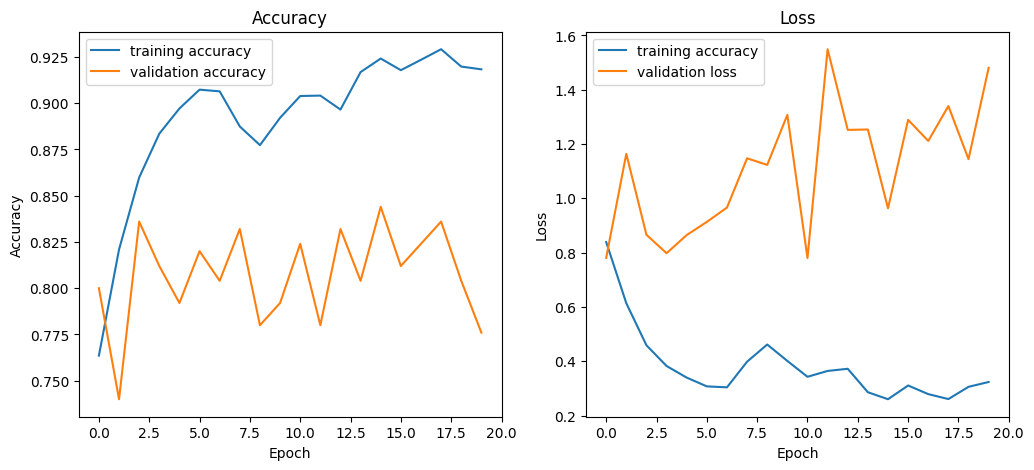

In [272]:
# accuracy plot
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axes[0].plot(hist['epoch'], hist['accuracy'], label='training accuracy')
axes[0].plot(hist['epoch'], hist['val_accuracy'], label='validation accuracy')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy")
axes[0].set_xlim(-1, 20)
axes[0].legend()

axes[1].plot(hist['epoch'], hist['loss'], label='training accuracy')
axes[1].plot(hist['epoch'], hist['val_loss'], label='validation loss')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].set_xlim(-1, 20)
axes[1].legend()

plt.show()

In [244]:
# Retrieve the history of the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Retrieve the last entry in the training and validation accuracy lists
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")


Final Training Accuracy: 91.83%
Final Validation Accuracy: 77.60%
